In [1]:
from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
from graviti import *
import networkx as nx
from scipy import sparse, linalg
import pickle

import multiprocessing
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')

In [2]:
def covd_local(r,A,data,row_idx,col_idx):
    mask = row_idx == r         # find nearest neigthbors
    cluster = np.append(r,col_idx[mask]) # define the local cluster, its size depends on the local connectivity
    a = A[r,cluster]
    a = np.hstack(([1],a.data))
    d = data[cluster,:]
    C = np.cov(d,rowvar=False,aweights=a)
    iu1 = np.triu_indices(C.shape[1])
    vec = C[iu1]
    return (r,vec)

In [14]:
dirname = '../h5/id_52/' # the path to *features.npz files 
sample = '52' #sys.argv[2]  # the sample id
size = 10000 # number of nuclei, use negative value for full set
nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well
N = 10 # number of linear bins for the contour visualization

features = ['area',
            'perimeter',
            'solidity',
            'eccentricity',
            'circularity',
            'mean_intensity',
            'std_intensity',
            'cov_intensity']


In [5]:
counter = 0
for f in glob.glob(dirname+'/*features.npz'): # for every fov
    counter += 1
    if counter == 1:            # set up the data arrays
        data = np.load(f,allow_pickle=True)
        fov = data['fov']
        xy = data['centroids']
        morphology = data['morphology']
    else:                       # update the data arrays
        data = np.load(f,allow_pickle=True)
        fov = np.vstack((fov,data['fov']))
        xy = np.vstack((xy, data['centroids']))
        morphology = np.vstack((morphology, data['morphology']))

# Create dataframes with spatial and morphological measurements
df_fov = pd.DataFrame(data=fov, columns=['fov_row','fov_col']) # field of view dataframe
df_xy = pd.DataFrame(data=xy, columns=['cx','cy'])   # centroid dataframe
df_morphology = pd.DataFrame(data=morphology, columns=['area','perimeter','solidity','eccentricity','circularity','mean_intensity','std_intensity'])

# Concatenate spatial and morphological dataframes
df = pd.concat([df_fov,df_xy, df_morphology],axis=1)

In [6]:
# filter by percentiles in morphologies (hardcoded in function filtering) and introduce coeff. of var
if size < 0:
    fdf = filtering(df) # filter out extremes in morphology
else:
    fdf = filtering(df).sample(n=size) # filter out morphological outlyers and subsample nuclei

pos = fdf[fdf.columns[2:4]].to_numpy() # Get the positions of centroids 

# Building the UMAP graph
filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.graph.npz' # the adj sparse matrix
if path.exists(filename):
    print('The graph already exists')
    A = sparse.load_npz(filename) 
else:
    print('Creating the graph')
    A = space2graph(pos,nn)
    sparse.save_npz(filename, A)
    
filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.graph.pickle'    # the networkx obj
if path.exists(filename):    
    print('The network already exists')
    G = nx.read_gpickle(filename)
else:
    print('Creating the network')
    G = nx.from_scipy_sparse_matrix(A, edge_attribute='weight')
    nx.write_gpickle(G, filename)

data = fdf[features].to_numpy() #get the morphological data

# Parallel generation of the local covd
filename = '../py/ID'+str(sample)+'.size'+str(size)+'.nn'+str(nn)+'.descriptor.pickle'    # the descriptor
if path.exists(filename):    
    print('The descriptor already exists')
    descriptor = pickle.load( open( filename, "rb" ) )
else:
    print('Generating the descriptor')
    num_cores = multiprocessing.cpu_count() # numb of cores
    row_idx, col_idx = A.nonzero() # nonzero entries
    processed_list = Parallel(n_jobs=num_cores)(delayed(covd_local)(r,A,data,row_idx,col_idx) 
                                                            for r in range(A.shape[0])
                                                   )

    # Construct the descriptor array
    descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]))
    for r in range(len(processed_list)):
        descriptor[r,:] = processed_list[r][1] # covd descriptors of the connected nodes
    pickle.dump( descriptor, open( filename, "wb" ) )
    
# Construct the local Laplacian
L = nx.laplacian_matrix(G, weight='weight') # get the Laplacian matrix
delta_descriptor = L.dot(descriptor) # get the local differianted descriptor
delta = norm(delta_descriptor,axis=1) # get the norm of the differential field

Creating the graph
Creating the network
Generating the descriptor


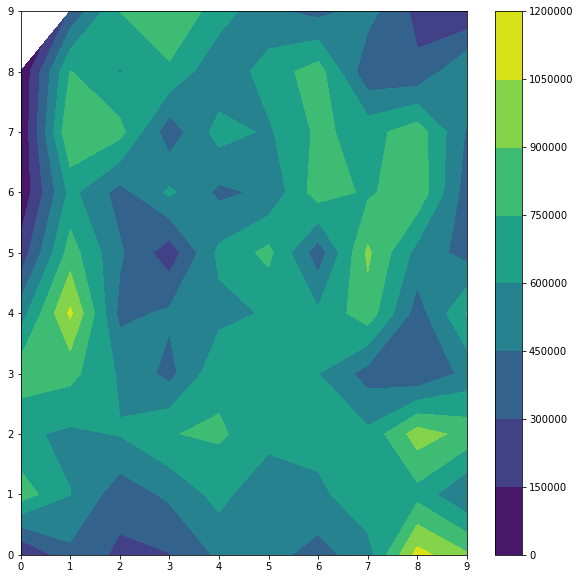

In [15]:
# Contour visualization
fdf['field'] = delta # define the laplacian field
fdf['x_bin'] = pd.cut(fdf['cx'], N, labels=False) # define the x bin label
fdf['y_bin'] = pd.cut(fdf['cy'], N, labels=False) # define the y bin label

# define the pivot tabel for the contour plot
table = pd.pivot_table(fdf, 
                       values='field', 
                       index=['x_bin'],
                       columns=['y_bin'],
                       aggfunc=np.sum, # take the mean of the entries in the bin
                       fill_value=None)

X=table.columns.values
Y=table.index.values
Z=table.values
Xi,Yi = np.meshgrid(X, Y)

fig, ax = plt.subplots(figsize=(10,10))
cs = ax.contourf(Yi, Xi, Z, 
                 alpha=1.0, 
                 levels=10,
                 cmap=plt.cm.viridis);
cbar = fig.colorbar(cs)
plt.savefig('test.png')